# Finetuning with Lora 

In [6]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "pandas"
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.3.0
pandas version: 2.2.2


- No code in this section
- Low-rank adaptation (LoRA) is a machine learning technique that modifies a pretrained model to better suit a specific, often smaller, dataset by adjusting only a small, low-rank subset of the model's parameters
- This approach is important because it allows for efficient finetuning of large models on task-specific data, significantly reducing the computational cost and time required for finetuning

## E.2 Preparing the dataset

In [12]:
from pathlib import Path
import pandas as pd
from module import (
    download_and_unzip_spam_data,
    create_balanced_dataset,
    random_split
)


url = "https://github.com/SURUJ-KALITA/Pytorch-/blob/main/sms%5Bspam%5D.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [16]:
import torch
from torch.utils.data import Dataset
import tiktoken
from module import SpamDataset


tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [18]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- As a verification step, we iterate through the data loaders and check that the batches contain 8 training examples each, where each training example consists of 120 tokens

In [42]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


- Lastly, let's print the total number of batches in each dataset

In [45]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


##  Initializing the model

In [47]:
from gpt_download import download_and_load_gpt2
from module import GPTModel, load_weights_into_gpt


CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves" 

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 77.0kiB/s]
encoder.json: 100%|███████████████████████████████████████████████████████████████| 1.04M/1.04M [00:05<00:00, 206kiB/s]
hparams.json: 100%|████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 30.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|███████████████████████████████████████████████| 498M/498M [11:55<00:00, 696kiB/s]
model.ckpt.index: 100%|██████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 5.20MiB/s]
model.ckpt.meta: 100%|██████████████████████████████████████████████████████████████| 471k/471k [00:01<00:00, 248kiB/s]
vocab.bpe: 100%|████████████████████████████████████████████████████████████████████| 456k/456k [00:01<00:00, 304kiB/s]


- To ensure that the model was loaded corrected, let's double-check that it generates coherent text

In [55]:
from module import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you "   #to be present in the text file of our sms/spm file 

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you  to the next step.
The first step is to find the right


- Then, we prepare the model for classification finetuning , where we replace the output layer

In [59]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

model.to(device);  # no assignment model = model.to(device) necessary for nn.Module classes

Using cpu device.


- Lastly, let's calculate the initial classification accuracy of the non-finetuned model (we expect this to be around 50%, which means that the model is not able to distinguish between spam and non-spam messages yet reliably)

In [66]:
from module import calc_accuracy_loader


torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


##  Parameter-efficient finetuning with LoRA

In [69]:
import math

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))  # similar to standard weight initialization
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

- To incorporate the original `Linear` layer weights as shown in the figure above, we implement a `LinearWithLoRA` layer below that uses the previously implemented LoRALayer and can be used to replace existing `Linear` layers in a neural network, for example, the self-attention module or feed forward modules in an LLM

In [92]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

- Note that since we initialize the weight matrix $B$ (`self.B` in `LoRALayer`) with zero values in the LoRA layer, the matrix multiplication between $A$ and $B$ results in a matrix consisting of 0's and doesn't affect the original weights (since adding 0 to the original weights does not modify them)

- To try LoRA on the GPT model we defined earlier, we define a `replace_linear_with_lora` function to replace all `Linear` layers in the model with the new `LinearWithLoRA` layers

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/appendix-e_compressed/lora-4.webp" width="400px">

In [94]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # Replace the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # Recursively apply the same function to child modules
            replace_linear_with_lora(module, rank, alpha)

- We then freeze the original model parameter and use the `replace_linear_with_lora` to replace the said `Linear` layers using the code below
- This will replace the `Linear` layers in the LLM with `LinearWithLoRA` layers

In [96]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 2,666,528
Total trainable parameters after: 0


In [98]:
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,528


- As we can see, we reduced the number of trainable parameters by almost 50x when using LoRA
- Let's now double-check whether the layers have been modified as intended by printing the model architecture

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): LinearWithLoRA(
            (linear): Linear(in_features=768, out_features=768, bias=True)
            (lora): LoRALayer()
          )
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): LinearWithLoRA(
            (linear): Linear(in_features=768, out_features=768, bias=True)
            (lora): LoRALayer()
          )
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): LinearWithLoRA(
            (linear): Linear(in_features=768, out_features=768, bias=True)
            (lora): LoRALayer()
          )
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): LinearWithLoRA(
            (linear): Linear(

- Based on the model architecture above, we can see that the model now contains our new `LinearWithLoRA` layers
- Also, since we initialized matrix $B$ with 0's, we expect the initial model performance to be unchanged compared to before

In [109]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


- Let's now get to the interesting part and finetune the model 
- The training takes about 15 minutes on a M3 MacBook Air laptop computer and less than half a minute on a V100 or A100 GPU

In [114]:
import time
from module import train_classifier_simple


start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.143, Val loss 0.922
Ep 1 (Step 000050): Train loss 0.248, Val loss 0.254
Ep 1 (Step 000100): Train loss 0.104, Val loss 0.201
Training accuracy: 90.00% | Validation accuracy: 85.00%
Ep 2 (Step 000150): Train loss 0.199, Val loss 0.193
Ep 2 (Step 000200): Train loss 0.029, Val loss 0.076
Ep 2 (Step 000250): Train loss 0.053, Val loss 0.202
Training accuracy: 95.00% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.086, Val loss 0.116
Ep 3 (Step 000350): Train loss 0.053, Val loss 0.438
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.005, Val loss 0.096
Ep 4 (Step 000450): Train loss 0.011, Val loss 0.149
Ep 4 (Step 000500): Train loss 0.074, Val loss 0.020
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.007, Val loss 0.182
Ep 5 (Step 000600): Train loss 0.111, Val loss 0.449
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 33.23 

- Finally, let's evaluate the model

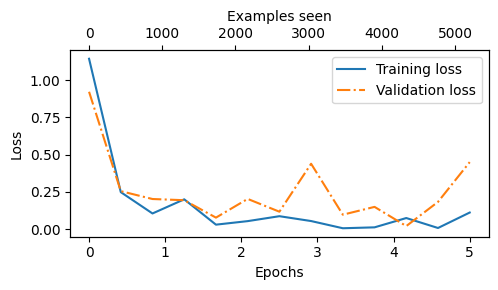

In [129]:
from module import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

- Note that we previously calculated the accuracy values on 5 batches only via the `eval_iter=5` setting; below, we calculate the accuracies on the full dataset

In [131]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.94%
Validation accuracy: 97.32%
Test accuracy: 96.33%


# Lora finetuning Successfully 